Enter the number of images to display (multiple of 3):  30


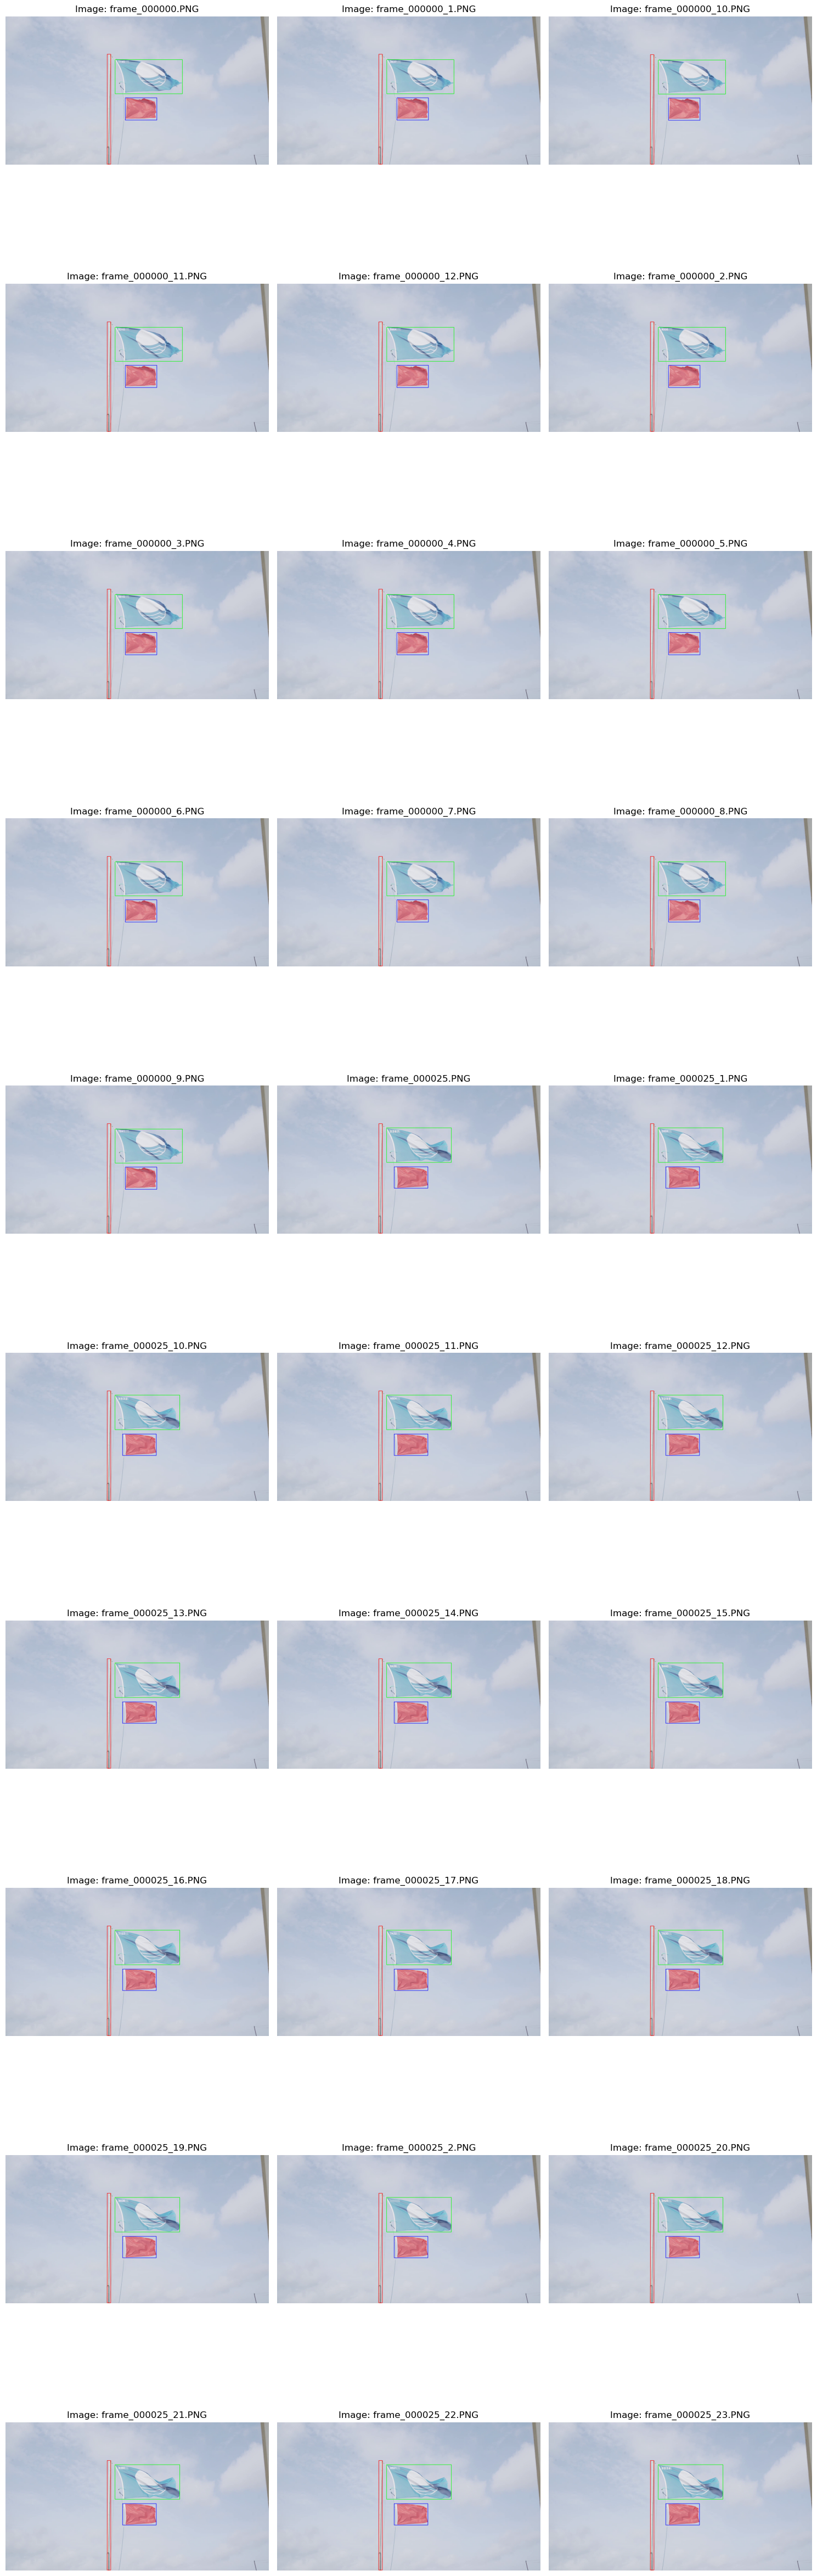

In [4]:
# Listing: Aug_Merge_Parent_and_Crop_by_Class_Coordinates.jpynb
# Used for Augmentation to replace text on Blue Flag using OCR - Used to assemble images 

import os
import cv2
import matplotlib.pyplot as plt

def merge_images(source_uncropped, cropped_segment, merged_folder, class_id):
    """
    Merges cropped segments into the corresponding uncropped source image based on annotations.

    Args:
        source_uncropped (str): Path to the folder containing the uncropped images.
        cropped_segment (str): Path to the folder containing cropped segments.
        merged_folder (str): Path to the folder where merged images and annotations will be saved.
        class_id (int): Class ID to locate coordinates in annotation files.

    Returns:
        None
    """
    if not os.path.exists(merged_folder):
        os.makedirs(merged_folder)

    # Group annotation files by their source uncropped file
    annotations = {}
    for file in os.listdir(source_uncropped):
        if file.endswith(".txt"):
            base_name = os.path.splitext(file)[0]
            annotations[base_name] = os.path.join(source_uncropped, file)

    # Process each uncropped source image
    for uncropped_file in os.listdir(source_uncropped):
        if uncropped_file.lower().endswith(('.png', '.jpg', '.jpeg')):
            base_name = os.path.splitext(uncropped_file)[0]
            uncropped_path = os.path.join(source_uncropped, uncropped_file)

            # Load the uncropped image
            uncropped_image = cv2.imread(uncropped_path)
            if uncropped_image is None:
                print(f"Error loading {uncropped_path}")
                continue

            # Process annotation file
            annotation_file = annotations.get(base_name)
            if not annotation_file:
                print(f"No annotation file found for {base_name}")
                continue

            with open(annotation_file, 'r') as f:
                annotation_lines = f.readlines()

            # Find all cropped segments related to the current source image
            related_segments = [
                file for file in os.listdir(cropped_segment)
                if file.startswith(base_name) and file.lower().endswith(('.png', '.jpg', '.jpeg'))
            ]
            related_segments.sort()  # Sort for consistent ordering

            # Process each related cropped segment
            for i, segment_file in enumerate(related_segments):
                segment_path = os.path.join(cropped_segment, segment_file)
                cropped_image = cv2.imread(segment_path)
                if cropped_image is None:
                    print(f"Error loading {segment_path}")
                    continue

                # Find coordinates for the specified class ID
                for line in annotation_lines:
                    line_parts = line.strip().split()
                    if len(line_parts) < 5:
                        continue

                    class_label, x_center, y_center, width, height = map(float, line_parts)
                    if int(class_label) == class_id:
                        # Calculate bounding box coordinates
                        x1 = int((x_center - width / 2) * uncropped_image.shape[1])
                        y1 = int((y_center - height / 2) * uncropped_image.shape[0])
                        x2 = int((x_center + width / 2) * uncropped_image.shape[1])
                        y2 = int((y_center + height / 2) * uncropped_image.shape[0])

                        # Merge the cropped image into the uncropped image
                        uncropped_image[y1:y2, x1:x2] = cv2.resize(
                            cropped_image, (x2 - x1, y2 - y1)
                        )

                # Save the merged image
                output_filename = f"{base_name}.PNG" if i == 0 else f"{base_name}_{i}.PNG"
                output_path = os.path.join(merged_folder, output_filename)
                cv2.imwrite(output_path, uncropped_image)

                # Copy and rename the annotation file
                annotation_output = os.path.join(merged_folder, f"{os.path.splitext(output_filename)[0]}.txt")
                with open(annotation_output, 'w') as out_f:
                    out_f.writelines(annotation_lines)

                print(f"Saved merged image and annotation: {output_filename}")

def preview_annotations_and_images(merged_folder, annotation_folder):
    """
    Previews images with bounding boxes drawn from their corresponding annotation files.
    Allows user to specify the number of images to display in multiples of 3.

    Args:
        merged_folder (str): Path to the folder containing merged images.
        annotation_folder (str): Path to the folder containing annotation files.

    Returns:
        None
    """
    # Input the number of files to display (must be a multiple of 3)
    while True:
        try:
            num_files_to_display = int(input("Enter the number of images to display (multiple of 3): "))
            if num_files_to_display % 3 != 0:
                print("Please enter a number that is a multiple of 3.")
                continue
            break
        except ValueError:
            print("Invalid input. Please enter an integer.")

    # List all image files in the merged folder
    image_files = [f for f in os.listdir(merged_folder) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    image_files = sorted(image_files)[:num_files_to_display]  # Limit to user-specified number of images

    # Define colors for bounding boxes
    colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255), (255, 255, 0), (255, 0, 255), (0, 255, 255)]

    # Calculate rows and columns
    columns = 3
    rows = len(image_files) // columns

    # Create a grid for displaying images
    fig, axes = plt.subplots(rows, columns, figsize=(15, 5 * rows))
    axes = axes.flatten()

    for i, image_file in enumerate(image_files):
        image_path = os.path.join(merged_folder, image_file)
        annotation_path = os.path.join(annotation_folder, os.path.splitext(image_file)[0] + '.txt')

        if not os.path.exists(annotation_path):
            print(f"No annotation found for image: {image_file}")
            axes[i].axis("off")
            axes[i].set_title(f"Missing annotation: {image_file}")
            continue

        # Load the image
        image = cv2.imread(image_path)
        if image is None:
            print(f"Error loading image: {image_file}")
            axes[i].axis("off")
            axes[i].set_title(f"Error loading: {image_file}")
            continue

        # Read annotations and draw bounding boxes
        with open(annotation_path, 'r') as f:
            annotations = f.readlines()

        for idx, annotation in enumerate(annotations):
            parts = annotation.strip().split()
            if len(parts) < 5:
                continue

            class_id, x_center, y_center, width, height = map(float, parts)

            # Convert YOLO format to pixel coordinates
            x_center = int(x_center * image.shape[1])
            y_center = int(y_center * image.shape[0])
            box_width = int(width * image.shape[1])
            box_height = int(height * image.shape[0])

            x1 = x_center - box_width // 2
            y1 = y_center - box_height // 2
            x2 = x_center + box_width // 2
            y2 = y_center + box_height // 2

            # Draw the bounding box
            color = colors[idx % len(colors)]  # Cycle through colors
            cv2.rectangle(image, (x1, y1), (x2, y2), color, 2)

        # Display the image with bounding boxes
        axes[i].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        axes[i].axis("off")
        axes[i].set_title(f"Image: {image_file}")

    # Remove unused axes
    for j in range(len(image_files), len(axes)):
        axes[j].axis("off")

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    source_uncropped = "D:/FlagDetectionDatasets/ExportedDatasetsReduced/Augmentation/FlagsWithYearOCR/Source_Uncropped"
    cropped_segment = "D:/FlagDetectionDatasets/ExportedDatasetsReduced/Augmentation/FlagsWithYearOCR/OCRReplacedYr"
    merged_folder = "D:/FlagDetectionDatasets/ExportedDatasetsReduced/Augmentation/FlagsWithYearOCR/Augmented_and_Merged"
    class_id = 2  # blue flag

    #merge_images(source_uncropped, cropped_segment, merged_folder, class_id)
    preview_annotations_and_images(merged_folder, merged_folder)

